## ANA500 - Python for Data Science

### Dave Terando

### Micro-Project 4: Machine Learning Part 2 (continued in Google Colab)

On an older MacBook with limited RAM and CPU-only processing, DNAMite (the NAM implementation) caused kernel crashes due to memory exhaustion, as the model builds a separate subnetwork for each feature. Ultimately, the local crashes prevented any usability of the NAM modeling, so I migrated to Google Colab for free cloud resources, including GPU acceleration, enabling larger models without hardware constraints.

In [ ]:
# Install DNAMite and other dependencies
!pip install dnamite scikit-learn pandas numpy matplotlib seaborn

In [1]:
# Verify installation
from dnamite.models import DNAMiteBinaryClassifier
print("DNAMite installed successfully!")

DNAMite installed successfully!


#### Started with the final code I tried on MacBook with only three features used.

df shape: (5000, 45)  – target: True
X_encoded_df shape: (5000, 27)

SVM metrics : {'name': 'SVM (Linear) – Tuned', 'accuracy': 0.718, 'precision': 0.2920353982300885, 'recall': 0.7021276595744681, 'f1': 0.4125, 'roc_auc': np.float64(0.7857520289962763)}

NAM (top‑3) metrics : {'name': 'DNAMite NAM (top‑3)', 'accuracy': 0.86, 'precision': 0.5151515151515151, 'recall': 0.12056737588652482, 'f1': 0.19540229885057472, 'roc_auc': np.float64(0.7081465335744186)}


,name,accuracy,precision,recall,f1,roc_auc
0,SVM (Linear) – Tuned,0.718000,0.292035,0.702128,0.412500,0.785752
1,DNAMite NAM (top‑3),0.860000,0.515152,0.120567,0.195402,0.708147


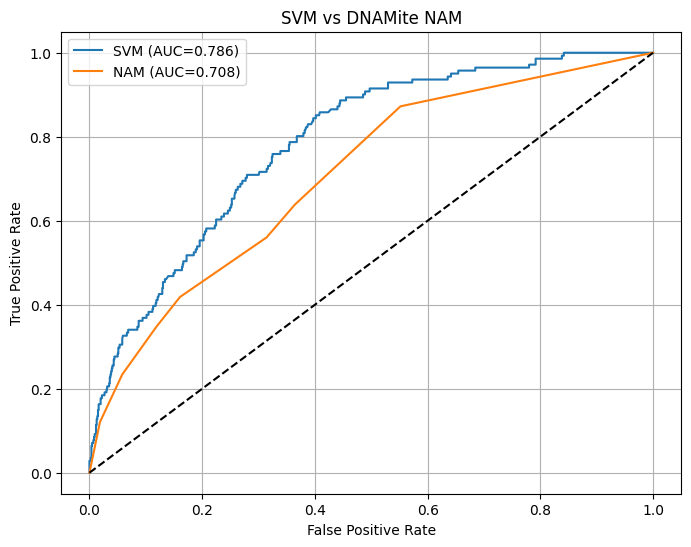

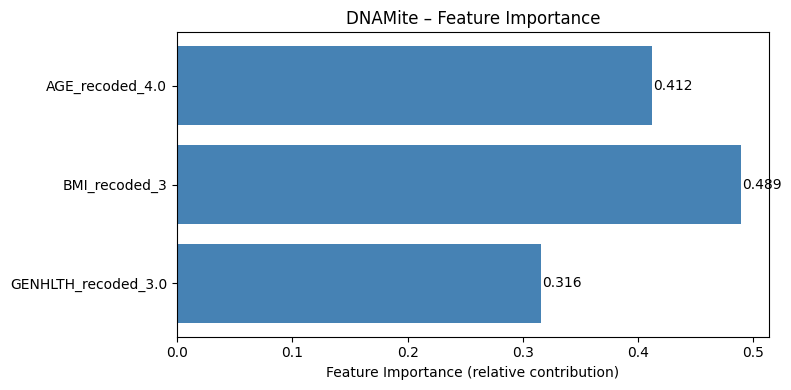

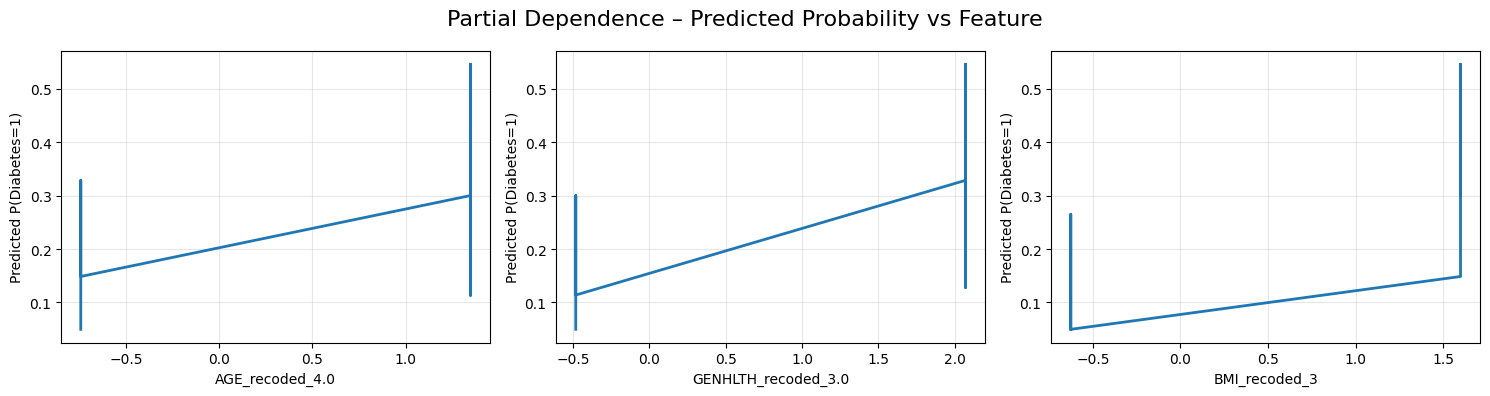

In [13]:
# ------------------------------------------------------------
# INITIAL COLAB CODE w/ TOP 3 FEATURES
# ------------------------------------------------------------

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'   # CPU only

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import *
from dnamite.models import DNAMiteBinaryClassifier

# ------------------------------------------------------------
# 1. Load CSVs
# ------------------------------------------------------------
df = pd.read_csv('/content/my_data_3.csv')
X_encoded_df = pd.read_csv('/content/x_encoded_df_2.csv')

print("df shape:", df.shape, " – target:", 'DIABETE3_binary' in df.columns)
print("X_encoded_df shape:", X_encoded_df.shape)

# ------------------------------------------------------------
# 2. Split & scale
# ------------------------------------------------------------
RANDOM_STATE = 42
y = df['DIABETE3_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_df, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

class_counts = y.value_counts()
class_weights = {0:1.0, 1:class_counts[0]/class_counts[1]}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=X_encoded_df.columns, index=X_train.index)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=X_encoded_df.columns, index=X_test.index)

# ------------------------------------------------------------
# 3. SVM baseline
# ------------------------------------------------------------
svm = SVC(kernel='linear', C=0.01, probability=True,
          class_weight=class_weights, random_state=RANDOM_STATE)
svm.fit(X_train_scaled, y_train)

y_score_svm = svm.decision_function(X_test_scaled)
y_pred_svm  = svm.predict(X_test_scaled)

svm_metrics = {
    "name": "SVM (Linear) – Tuned",
    "accuracy": accuracy_score(y_test, y_pred_svm),
    "precision": precision_score(y_test, y_pred_svm, zero_division=0),
    "recall": recall_score(y_test, y_pred_svm),
    "f1": f1_score(y_test, y_pred_svm),
    "roc_auc": roc_auc_score(y_test, y_score_svm)
}
print("\nSVM metrics :", svm_metrics)

# ------------------------------------------------------------
# 4. NAM – top‑3 features
# ------------------------------------------------------------
top3_features = ['AGE_recoded_4.0', 'GENHLTH_recoded_3.0', 'BMI_recoded_3']
X_train_top = X_train_df[top3_features].copy()
X_test_top  = X_test_df[top3_features].copy()

nam = DNAMiteBinaryClassifier(
    X_train_top.shape[1],
    max_bins=8,
    min_samples_per_bin=20,
    random_state=RANDOM_STATE
)
nam.fit(X_train_top, y_train)

y_score_nam = nam.predict_proba(X_test_top).flatten()
y_pred_nam  = (y_score_nam >= 0.5).astype(int)

nam_metrics = {
    "name": "DNAMite NAM (top‑3)",
    "accuracy": accuracy_score(y_test, y_pred_nam),
    "precision": precision_score(y_test, y_pred_nam, zero_division=0),
    "recall": recall_score(y_test, y_pred_nam),
    "f1": f1_score(y_test, y_pred_nam),
    "roc_auc": roc_auc_score(y_test, y_score_nam)
}
print("\nNAM (top‑3) metrics :", nam_metrics)

# ------------------------------------------------------------
# 5. Comparison table
# ------------------------------------------------------------
results = pd.DataFrame([svm_metrics, nam_metrics])\
            .sort_values(by=["f1","roc_auc"], ascending=False)
styled = results.style.highlight_max(
    subset=["accuracy","precision","recall","f1","roc_auc"], color="#2E8B57")
display(styled)

# ------------------------------------------------------------
# 6. ROC curve
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
for name, scores in [("SVM", y_score_svm), ("NAM", y_score_nam)]:
    fpr, tpr, _ = roc_curve(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,scores):.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM vs DNAMite NAM")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 7. FEATURE IMPORTANCE BAR CHART (public API)
# ------------------------------------------------------------
# Get feature importances using the public attribute
importances_df = nam.get_feature_importances()
# Calculate the mean importance across splits
importances = importances_df.groupby('feature')['importance'].mean().reset_index()
feat_names = importances['feature'].tolist()
importance_values = importances['importance'].tolist()


plt.figure(figsize=(8,4))
bars = plt.barh(feat_names, importance_values, color='steelblue')
plt.xlabel("Feature Importance (relative contribution)")
plt.title("DNAMite – Feature Importance")
plt.gca().invert_yaxis()

# Add values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', ha='left', fontsize=10)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8. PARTIAL DEPENDENCE SCATTER PLOTS
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle("Partial Dependence – Predicted Probability vs Feature", fontsize=16)

for i, feat in enumerate(top3_features):
    # Feature values
    x = X_test_top.iloc[:, i].values
    # Predicted probability (using the full NAM)
    prob = nam.predict_proba(X_test_top)[:, 0] if nam.predict_proba(X_test_top).ndim > 1 else nam.predict_proba(X_test_top).flatten()

    # Sort for smooth line
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    prob_sorted = prob[sort_idx]

    axes[i].plot(x_sorted, prob_sorted, color='tab:blue', linewidth=2) # Changed to plot a line
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("Predicted P(Diabetes=1)")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

After succesful run with only three features, and after figuring out how to access the GPU support on Colab, I ran the Nam model again, this time with 5 features.

df shape: (5000, 45)  – target: True
X_encoded_df shape: (5000, 27)

SVM metrics : {'name': 'SVM (Linear) – Tuned', 'accuracy': 0.718, 'precision': 0.2920353982300885, 'recall': 0.7021276595744681, 'f1': 0.4125, 'roc_auc': np.float64(0.7857520289962763)}

NAM (top-5) metrics : {'name': 'DNAMite NAM (top-5)', 'accuracy': 0.86, 'precision': 0.5151515151515151, 'recall': 0.12056737588652482, 'f1': 0.19540229885057472, 'roc_auc': np.float64(0.7630347014093577)}


,name,accuracy,precision,recall,f1,roc_auc
0,SVM (Linear) – Tuned,0.718000,0.292035,0.702128,0.412500,0.785752
1,DNAMite NAM (top-5),0.860000,0.515152,0.120567,0.195402,0.763035


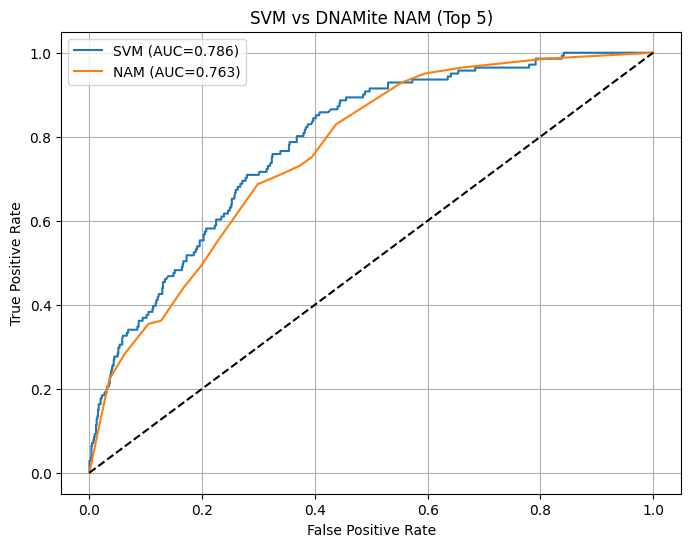

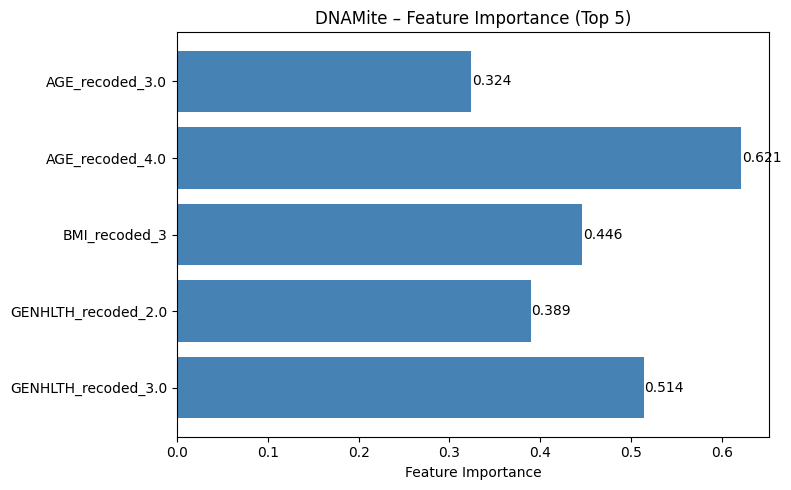

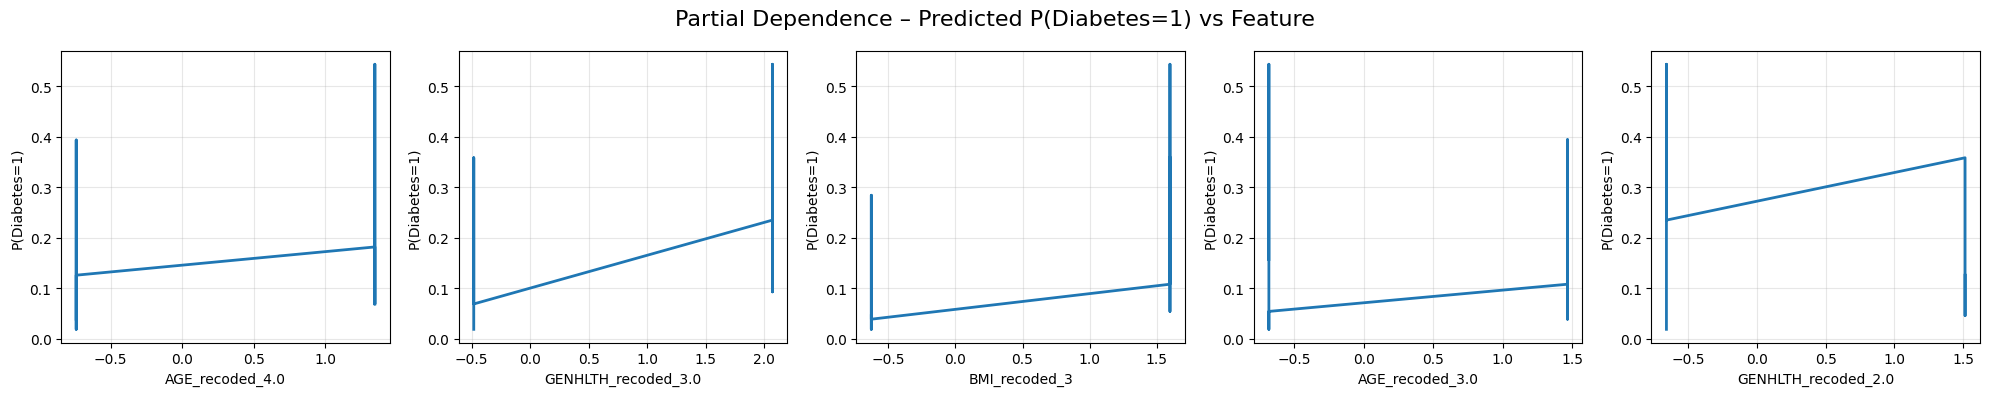

In [14]:
# ------------------------------------------------------------
# UPGRADED: Top 5 Features + GPU Support
# ------------------------------------------------------------

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import *
from dnamite.models import DNAMiteBinaryClassifier

# ------------------------------------------------------------
# 1. Load CSVs
# ------------------------------------------------------------
df = pd.read_csv('/content/my_data_3.csv')
X_encoded_df = pd.read_csv('/content/x_encoded_df_2.csv')

print("df shape:", df.shape, " – target:", 'DIABETE3_binary' in df.columns)
print("X_encoded_df shape:", X_encoded_df.shape)

# ------------------------------------------------------------
# 2. Split & scale
# ------------------------------------------------------------
RANDOM_STATE = 42
y = df['DIABETE3_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_df, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

class_counts = y.value_counts()
class_weights = {0:1.0, 1:class_counts[0]/class_counts[1]}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=X_encoded_df.columns, index=X_train.index)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=X_encoded_df.columns, index=X_test.index)

# ------------------------------------------------------------
# 3. SVM baseline
# ------------------------------------------------------------
svm = SVC(kernel='linear', C=0.01, probability=True,
          class_weight=class_weights, random_state=RANDOM_STATE)
svm.fit(X_train_scaled, y_train)

y_score_svm = svm.decision_function(X_test_scaled)
y_pred_svm  = svm.predict(X_test_scaled)

svm_metrics = {
    "name": "SVM (Linear) – Tuned",
    "accuracy": accuracy_score(y_test, y_pred_svm),
    "precision": precision_score(y_test, y_pred_svm, zero_division=0),
    "recall": recall_score(y_test, y_pred_svm),
    "f1": f1_score(y_test, y_pred_svm),
    "roc_auc": roc_auc_score(y_test, y_score_svm)
}
print("\nSVM metrics :", svm_metrics)

# ------------------------------------------------------------
# 4. NAM – TOP 5 FEATURES
# ------------------------------------------------------------
top5_features = [
    'AGE_recoded_4.0',
    'GENHLTH_recoded_3.0',
    'BMI_recoded_3',
    'AGE_recoded_3.0',      # added
    'GENHLTH_recoded_2.0'   # added
]

X_train_top = X_train_df[top5_features].copy()
X_test_top  = X_test_df[top5_features].copy()

nam = DNAMiteBinaryClassifier(
    X_train_top.shape[1],
    max_bins=16,                # ↑ increased for better resolution
    min_samples_per_bin=20,
    random_state=RANDOM_STATE
)
nam.fit(X_train_top, y_train)

y_score_nam = nam.predict_proba(X_test_top).flatten()
y_pred_nam  = (y_score_nam >= 0.5).astype(int)

nam_metrics = {
    "name": "DNAMite NAM (top-5)",
    "accuracy": accuracy_score(y_test, y_pred_nam),
    "precision": precision_score(y_test, y_pred_nam, zero_division=0),
    "recall": recall_score(y_test, y_pred_nam),
    "f1": f1_score(y_test, y_pred_nam),
    "roc_auc": roc_auc_score(y_test, y_score_nam)
}
print("\nNAM (top-5) metrics :", nam_metrics)

# 5. Comparison table
# ------------------------------------------------------------
results = pd.DataFrame([svm_metrics, nam_metrics])\
            .sort_values(by=["f1","roc_auc"], ascending=False)
styled = results.style.highlight_max(
    subset=["accuracy","precision","recall","f1","roc_auc"], color="#2E8B57")
display(styled)

# ------------------------------------------------------------
# 6. ROC curve
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
for name, scores in [("SVM", y_score_svm), ("NAM", y_score_nam)]:
    fpr, tpr, _ = roc_curve(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,scores):.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM vs DNAMite NAM (Top 5)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 7. FEATURE IMPORTANCE BAR CHART
# ------------------------------------------------------------
importances_df = nam.get_feature_importances()
importances = importances_df.groupby('feature')['importance'].mean().reset_index()
feat_names = importances['feature'].tolist()
importance_values = importances['importance'].tolist()

plt.figure(figsize=(8,5))
bars = plt.barh(feat_names, importance_values, color='steelblue')
plt.xlabel("Feature Importance")
plt.title("DNAMite – Feature Importance (Top 5)")
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', ha='left', fontsize=10)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8. PARTIAL DEPENDENCE PLOTS (5 features)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 5, figsize=(20,4))
fig.suptitle("Partial Dependence – Predicted P(Diabetes=1) vs Feature", fontsize=16)

for i, feat in enumerate(top5_features):
    x = X_test_top.iloc[:, i].values
    prob = nam.predict_proba(X_test_top).flatten()

    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    prob_sorted = prob[sort_idx]

    axes[i].plot(x_sorted, prob_sorted, color='tab:blue', linewidth=2)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("P(Diabetes=1)")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

After sucessful run with 5 features, I attempted to run with 10 features to assess continued improvement.

df shape: (5000, 45)  – target: True
X_encoded_df shape: (5000, 27)

SVM metrics : {'name': 'SVM (Linear) – Tuned', 'accuracy': 0.718, 'precision': 0.2920353982300885, 'recall': 0.7021276595744681, 'f1': 0.4125, 'roc_auc': np.float64(0.7857520289962763)}

NAM (top-10) metrics : {'name': 'DNAMite NAM (top-10)', 'accuracy': 0.858, 'precision': 0.4883720930232558, 'recall': 0.14893617021276595, 'f1': 0.22826086956521738, 'roc_auc': np.float64(0.7777929144064928)}


,name,accuracy,precision,recall,f1,roc_auc
0,SVM (Linear) – Tuned,0.718000,0.292035,0.702128,0.412500,0.785752
1,DNAMite NAM (top-10),0.858000,0.488372,0.148936,0.228261,0.777793


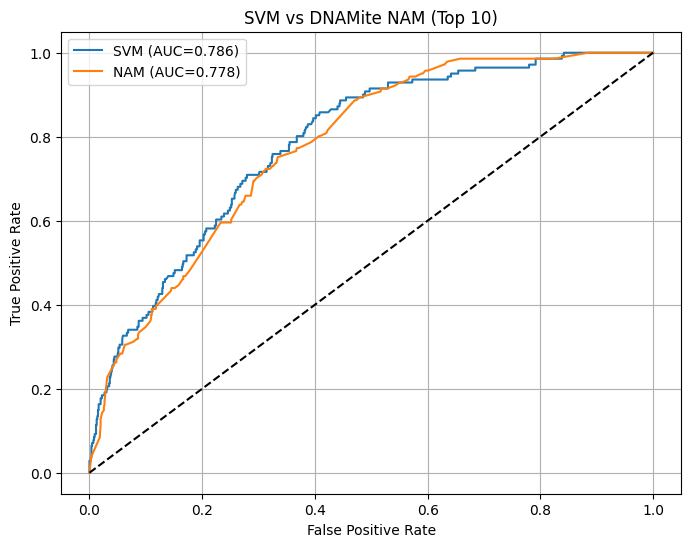

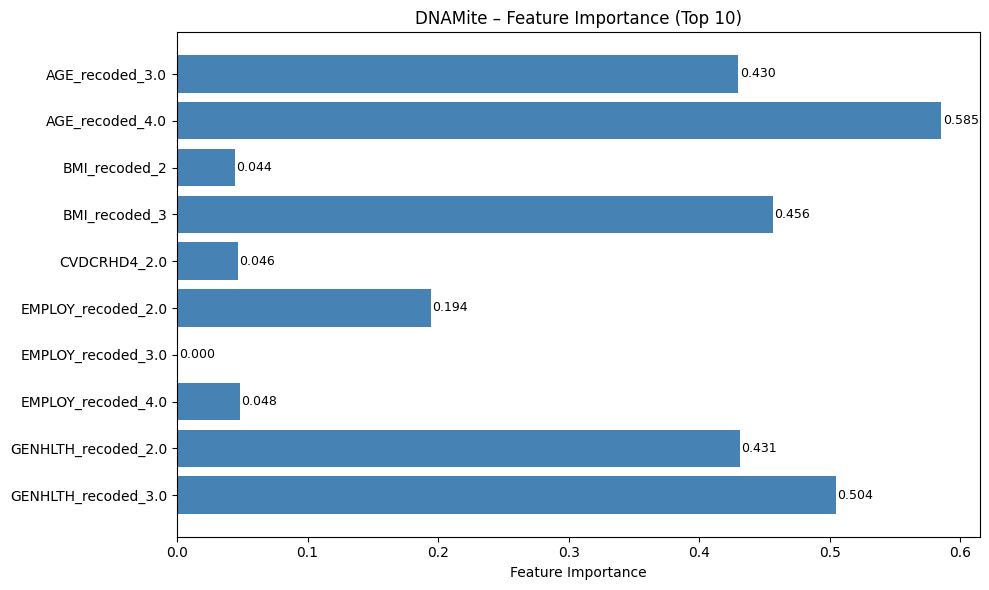

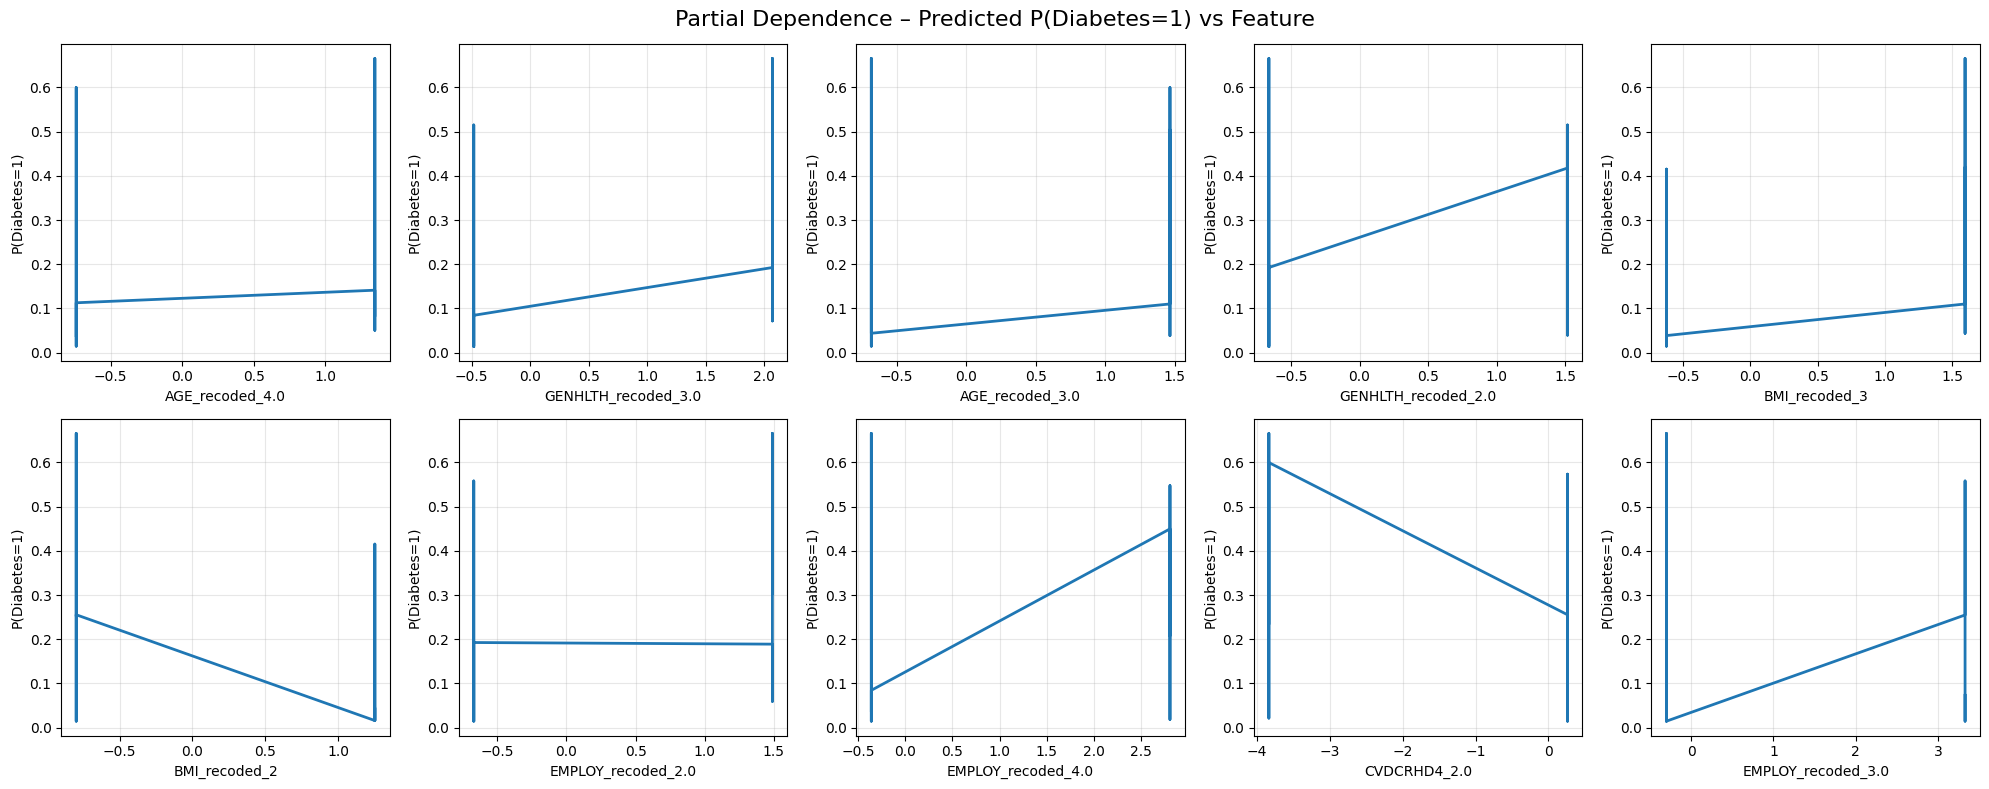

In [16]:
# ------------------------------------------------------------
# DNAMite NAM – TOP 10 FEATURES + GPU + FULL VISUALIZATIONS
# ------------------------------------------------------------

# GPU is ENABLED (no restriction)
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'   ← REMOVED

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import *
from dnamite.models import DNAMiteBinaryClassifier

# ------------------------------------------------------------
# 1. Load CSVs
# ------------------------------------------------------------
df = pd.read_csv('/content/my_data_3.csv')
X_encoded_df = pd.read_csv('/content/x_encoded_df_2.csv')

print("df shape:", df.shape, " – target:", 'DIABETE3_binary' in df.columns)
print("X_encoded_df shape:", X_encoded_df.shape)

# ------------------------------------------------------------
# 2. Split & scale
# ------------------------------------------------------------
RANDOM_STATE = 42
y = df['DIABETE3_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_df, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

class_counts = y.value_counts()
class_weights = {0:1.0, 1:class_counts[0]/class_counts[1]}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=X_encoded_df.columns, index=X_train.index)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=X_encoded_df.columns, index=X_test.index)

# ------------------------------------------------------------
# 3. SVM baseline
# ------------------------------------------------------------
svm = SVC(kernel='linear', C=0.01, probability=True,
          class_weight=class_weights, random_state=RANDOM_STATE)
svm.fit(X_train_scaled, y_train)

y_score_svm = svm.decision_function(X_test_scaled)
y_pred_svm  = svm.predict(X_test_scaled)

svm_metrics = {
    "name": "SVM (Linear) – Tuned",
    "accuracy": accuracy_score(y_test, y_pred_svm),
    "precision": precision_score(y_test, y_pred_svm, zero_division=0),
    "recall": recall_score(y_test, y_pred_svm),
    "f1": f1_score(y_test, y_pred_svm),
    "roc_auc": roc_auc_score(y_test, y_score_svm)
}
print("\nSVM metrics :", svm_metrics)

# ------------------------------------------------------------
# 4. NAM – TOP 10 FEATURES
# ------------------------------------------------------------
top10_features = [
    'AGE_recoded_4.0',
    'GENHLTH_recoded_3.0',
    'AGE_recoded_3.0',
    'GENHLTH_recoded_2.0',
    'BMI_recoded_3',
    'BMI_recoded_2',
    'EMPLOY_recoded_2.0',
    'EMPLOY_recoded_4.0',
    'CVDCRHD4_2.0',
    'EMPLOY_recoded_3.0'
]

X_train_top = X_train_df[top10_features].copy()
X_test_top  = X_test_df[top10_features].copy()

nam = DNAMiteBinaryClassifier(
    X_train_top.shape[1],
    max_bins=32,                 # ↑ better resolution
    min_samples_per_bin=15,
    random_state=RANDOM_STATE
)
nam.fit(X_train_top, y_train)

y_score_nam = nam.predict_proba(X_test_top).flatten()
y_pred_nam  = (y_score_nam >= 0.5).astype(int)  # default threshold

nam_metrics = {
    "name": "DNAMite NAM (top-10)",
    "accuracy": accuracy_score(y_test, y_pred_nam),
    "precision": precision_score(y_test, y_pred_nam, zero_division=0),
    "recall": recall_score(y_test, y_pred_nam),
    "f1": f1_score(y_test, y_pred_nam),
    "roc_auc": roc_auc_score(y_test, y_score_nam)
}
print("\nNAM (top-10) metrics :", nam_metrics)

# ------------------------------------------------------------
# 5. Comparison table
# ------------------------------------------------------------
results = pd.DataFrame([svm_metrics, nam_metrics])\
            .sort_values(by=["f1","roc_auc"], ascending=False)
styled = results.style.highlight_max(
    subset=["accuracy","precision","recall","f1","roc_auc"], color="#2E8B57")
display(styled)

# ------------------------------------------------------------
# 6. ROC curve
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
for name, scores in [("SVM", y_score_svm), ("NAM", y_score_nam)]:
    fpr, tpr, _ = roc_curve(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,scores):.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM vs DNAMite NAM (Top 10)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 7. FEATURE IMPORTANCE BAR CHART
# ------------------------------------------------------------
importances_df = nam.get_feature_importances()
importances = importances_df.groupby('feature')['importance'].mean().reset_index()
feat_names = importances['feature'].tolist()
importance_values = importances['importance'].tolist()

plt.figure(figsize=(10,6))
bars = plt.barh(feat_names, importance_values, color='steelblue')
plt.xlabel("Feature Importance")
plt.title("DNAMite – Feature Importance (Top 10)")
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', ha='left', fontsize=9)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8. PARTIAL DEPENDENCE PLOTS (10 features)
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(20,8))
fig.suptitle("Partial Dependence – Predicted P(Diabetes=1) vs Feature", fontsize=16)

for i, feat in enumerate(top10_features):
    ax = axes[i//5, i%5]
    x = X_test_top.iloc[:, i].values
    prob = nam.predict_proba(X_test_top).flatten()

    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    prob_sorted = prob[sort_idx]

    ax.plot(x_sorted, prob_sorted, color='tab:blue', linewidth=2)
    ax.set_xlabel(feat)
    ax.set_ylabel("P(Diabetes=1)")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# ------------------------------------------------------------
# DNAMite NAM (Top‑10) + THRESHOLD TUNING
# ------------------------------------------------------------

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import *
from dnamite.models import DNAMiteBinaryClassifier
from sklearn.metrics import precision_recall_curve

# ------------------------------------------------------------
# 1. Load CSVs
# ------------------------------------------------------------
df = pd.read_csv('/content/my_data_3.csv')
X_encoded_df = pd.read_csv('/content/x_encoded_df_2.csv')

# ------------------------------------------------------------
# 2. Split & scale
# ------------------------------------------------------------
RANDOM_STATE = 42
y = df['DIABETE3_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_df, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

class_counts = y.value_counts()
class_weights = {0:1.0, 1:class_counts[0]/class_counts[1]}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=X_encoded_df.columns, index=X_train.index)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=X_encoded_df.columns, index=X_test.index)

# ------------------------------------------------------------
# 3. SVM baseline (for reference)
# ------------------------------------------------------------
svm = SVC(kernel='linear', C=0.01, probability=True,
          class_weight=class_weights, random_state=RANDOM_STATE)
svm.fit(X_train_scaled, y_train)

y_score_svm = svm.decision_function(X_test_scaled)
y_pred_svm  = svm.predict(X_test_scaled)

svm_metrics = {
    "name": "SVM (Linear) – Tuned",
    "accuracy": accuracy_score(y_test, y_pred_svm),
    "precision": precision_score(y_test, y_pred_svm, zero_division=0),
    "recall": recall_score(y_test, y_pred_svm),
    "f1": f1_score(y_test, y_pred_svm),
    "roc_auc": roc_auc_score(y_test, y_score_svm)
}
print("SVM metrics :", svm_metrics)

# ------------------------------------------------------------
# 4. NAM – TOP 10 FEATURES (from SVM coefficients)
# ------------------------------------------------------------
top10_features = [
    'AGE_recoded_4.0',
    'GENHLTH_recoded_3.0',
    'AGE_recoded_3.0',
    'GENHLTH_recoded_2.0',
    'BMI_recoded_3',
    'BMI_recoded_2',
    'EMPLOY_recoded_2.0',
    'EMPLOY_recoded_4.0',
    'CVDCRHD4_2.0',
    'EMPLOY_recoded_3.0'
]

X_train_top = X_train_df[top10_features].copy()
X_test_top  = X_test_df[top10_features].copy()

nam = DNAMiteBinaryClassifier(
    X_train_top.shape[1],
    max_bins=32,
    min_samples_per_bin=15,
    random_state=RANDOM_STATE
)
nam.fit(X_train_top, y_train)

y_score_nam = nam.predict_proba(X_test_top).flatten()

# ------------------------------------------------------------
# 5. THRESHOLD TUNING: Match SVM recall (~0.702)
# ------------------------------------------------------------
prec, rec, thresh = precision_recall_curve(y_test, y_score_nam)
target_recall = 0.702
idx = np.argmin(np.abs(rec - target_recall))
best_thresh = thresh[idx] if idx < len(thresh) else 0.5

print(f"\nThreshold search: target recall = {target_recall}")
print(f"→ Best threshold = {best_thresh:.4f}")
print(f"   Recall = {rec[idx]:.4f}, Precision = {prec[idx]:.4f}")

y_pred_tuned = (y_score_nam >= best_thresh).astype(int)

nam_tuned_metrics = {
    "name": "DNAMite NAM (top-10, tuned)",
    "accuracy": accuracy_score(y_test, y_pred_tuned),
    "precision": precision_score(y_test, y_pred_tuned, zero_division=0),
    "recall": recall_score(y_test, y_pred_tuned),
    "f1": f1_score(y_test, y_pred_tuned),
    "roc_auc": roc_auc_score(y_test, y_score_nam)
}
print("\nTuned NAM metrics :", nam_tuned_metrics)

# ------------------------------------------------------------
# 6. Final comparison table
# ------------------------------------------------------------
results = pd.DataFrame([svm_metrics, nam_tuned_metrics])\
            .sort_values(by=["f1","roc_auc"], ascending=False)
styled = results.style.highlight_max(
    subset=["accuracy","precision","recall","f1","roc_auc"], color="#2E8B57")
display(styled)

SVM metrics : {'name': 'SVM (Linear) – Tuned', 'accuracy': 0.718, 'precision': 0.2920353982300885, 'recall': 0.7021276595744681, 'f1': 0.4125, 'roc_auc': np.float64(0.7857520289962763)}

Threshold search: target recall = 0.702
→ Best threshold = 0.1492
   Recall = 0.7021, Precision = 0.2797

Tuned NAM metrics : {'name': 'DNAMite NAM (top-10, tuned)', 'accuracy': 0.703, 'precision': 0.2796610169491525, 'recall': 0.7021276595744681, 'f1': 0.4, 'roc_auc': np.float64(0.7777929144064928)}


,name,accuracy,precision,recall,f1,roc_auc
0,SVM (Linear) – Tuned,0.718000,0.292035,0.702128,0.412500,0.785752
1,"DNAMite NAM (top-10, tuned)",0.703000,0.279661,0.702128,0.400000,0.777793


Finally, after success with 10 features I attemped to run the full 27 features.

df shape: (5000, 45)  – target: True
X_encoded_df shape: (5000, 27)

SVM metrics : {'name': 'SVM (Linear) – Tuned', 'accuracy': 0.718, 'precision': 0.2920353982300885, 'recall': 0.7021276595744681, 'f1': 0.4125, 'roc_auc': np.float64(0.7857520289962763)}

NAM (full) metrics : {'name': 'DNAMite NAM (full)', 'accuracy': 0.865, 'precision': 0.5652173913043478, 'recall': 0.18439716312056736, 'f1': 0.27807486631016043, 'roc_auc': np.float64(0.7741188418002131)}


,name,accuracy,precision,recall,f1,roc_auc
0,SVM (Linear) – Tuned,0.718000,0.292035,0.702128,0.412500,0.785752
1,DNAMite NAM (full),0.865000,0.565217,0.184397,0.278075,0.774119


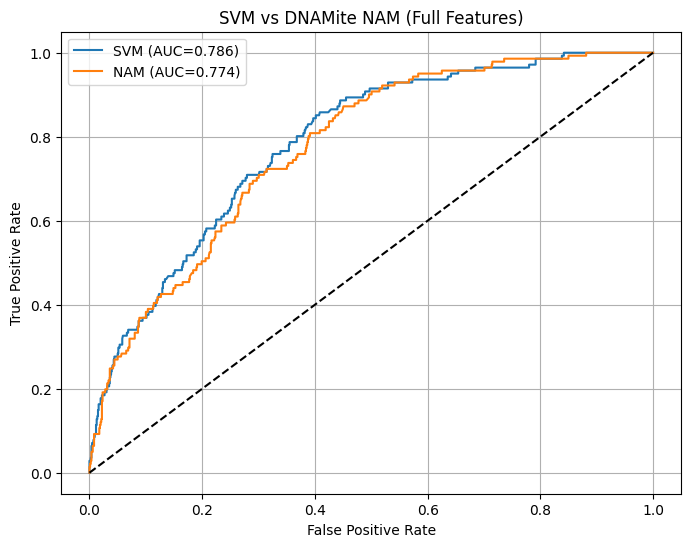

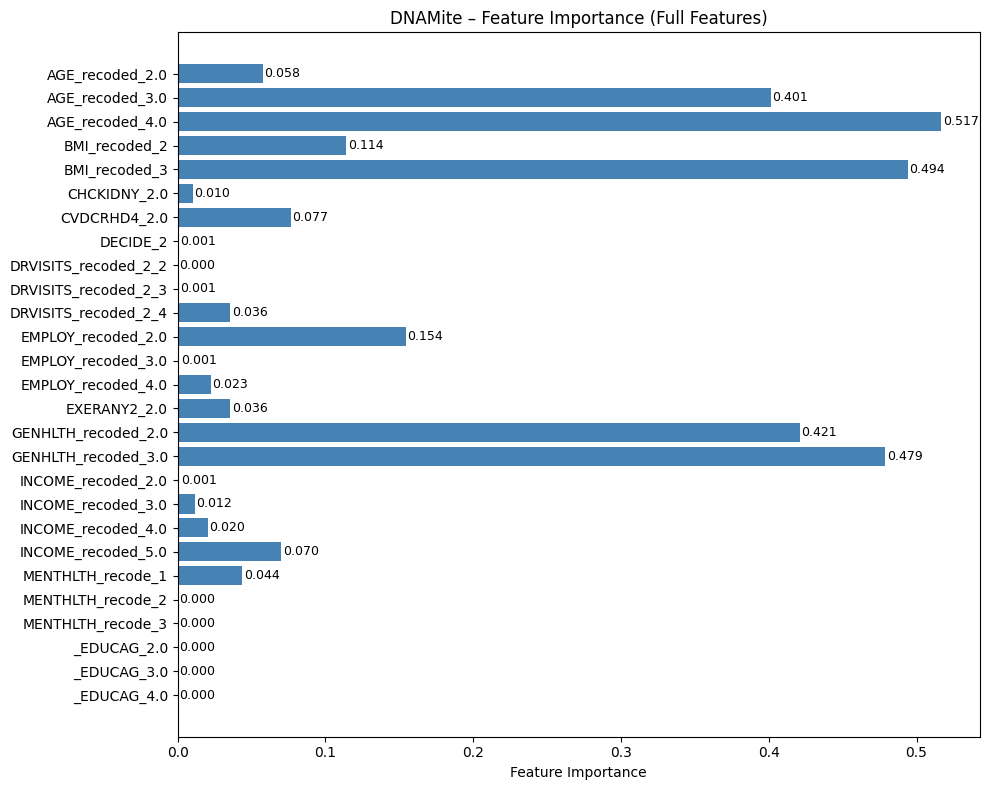

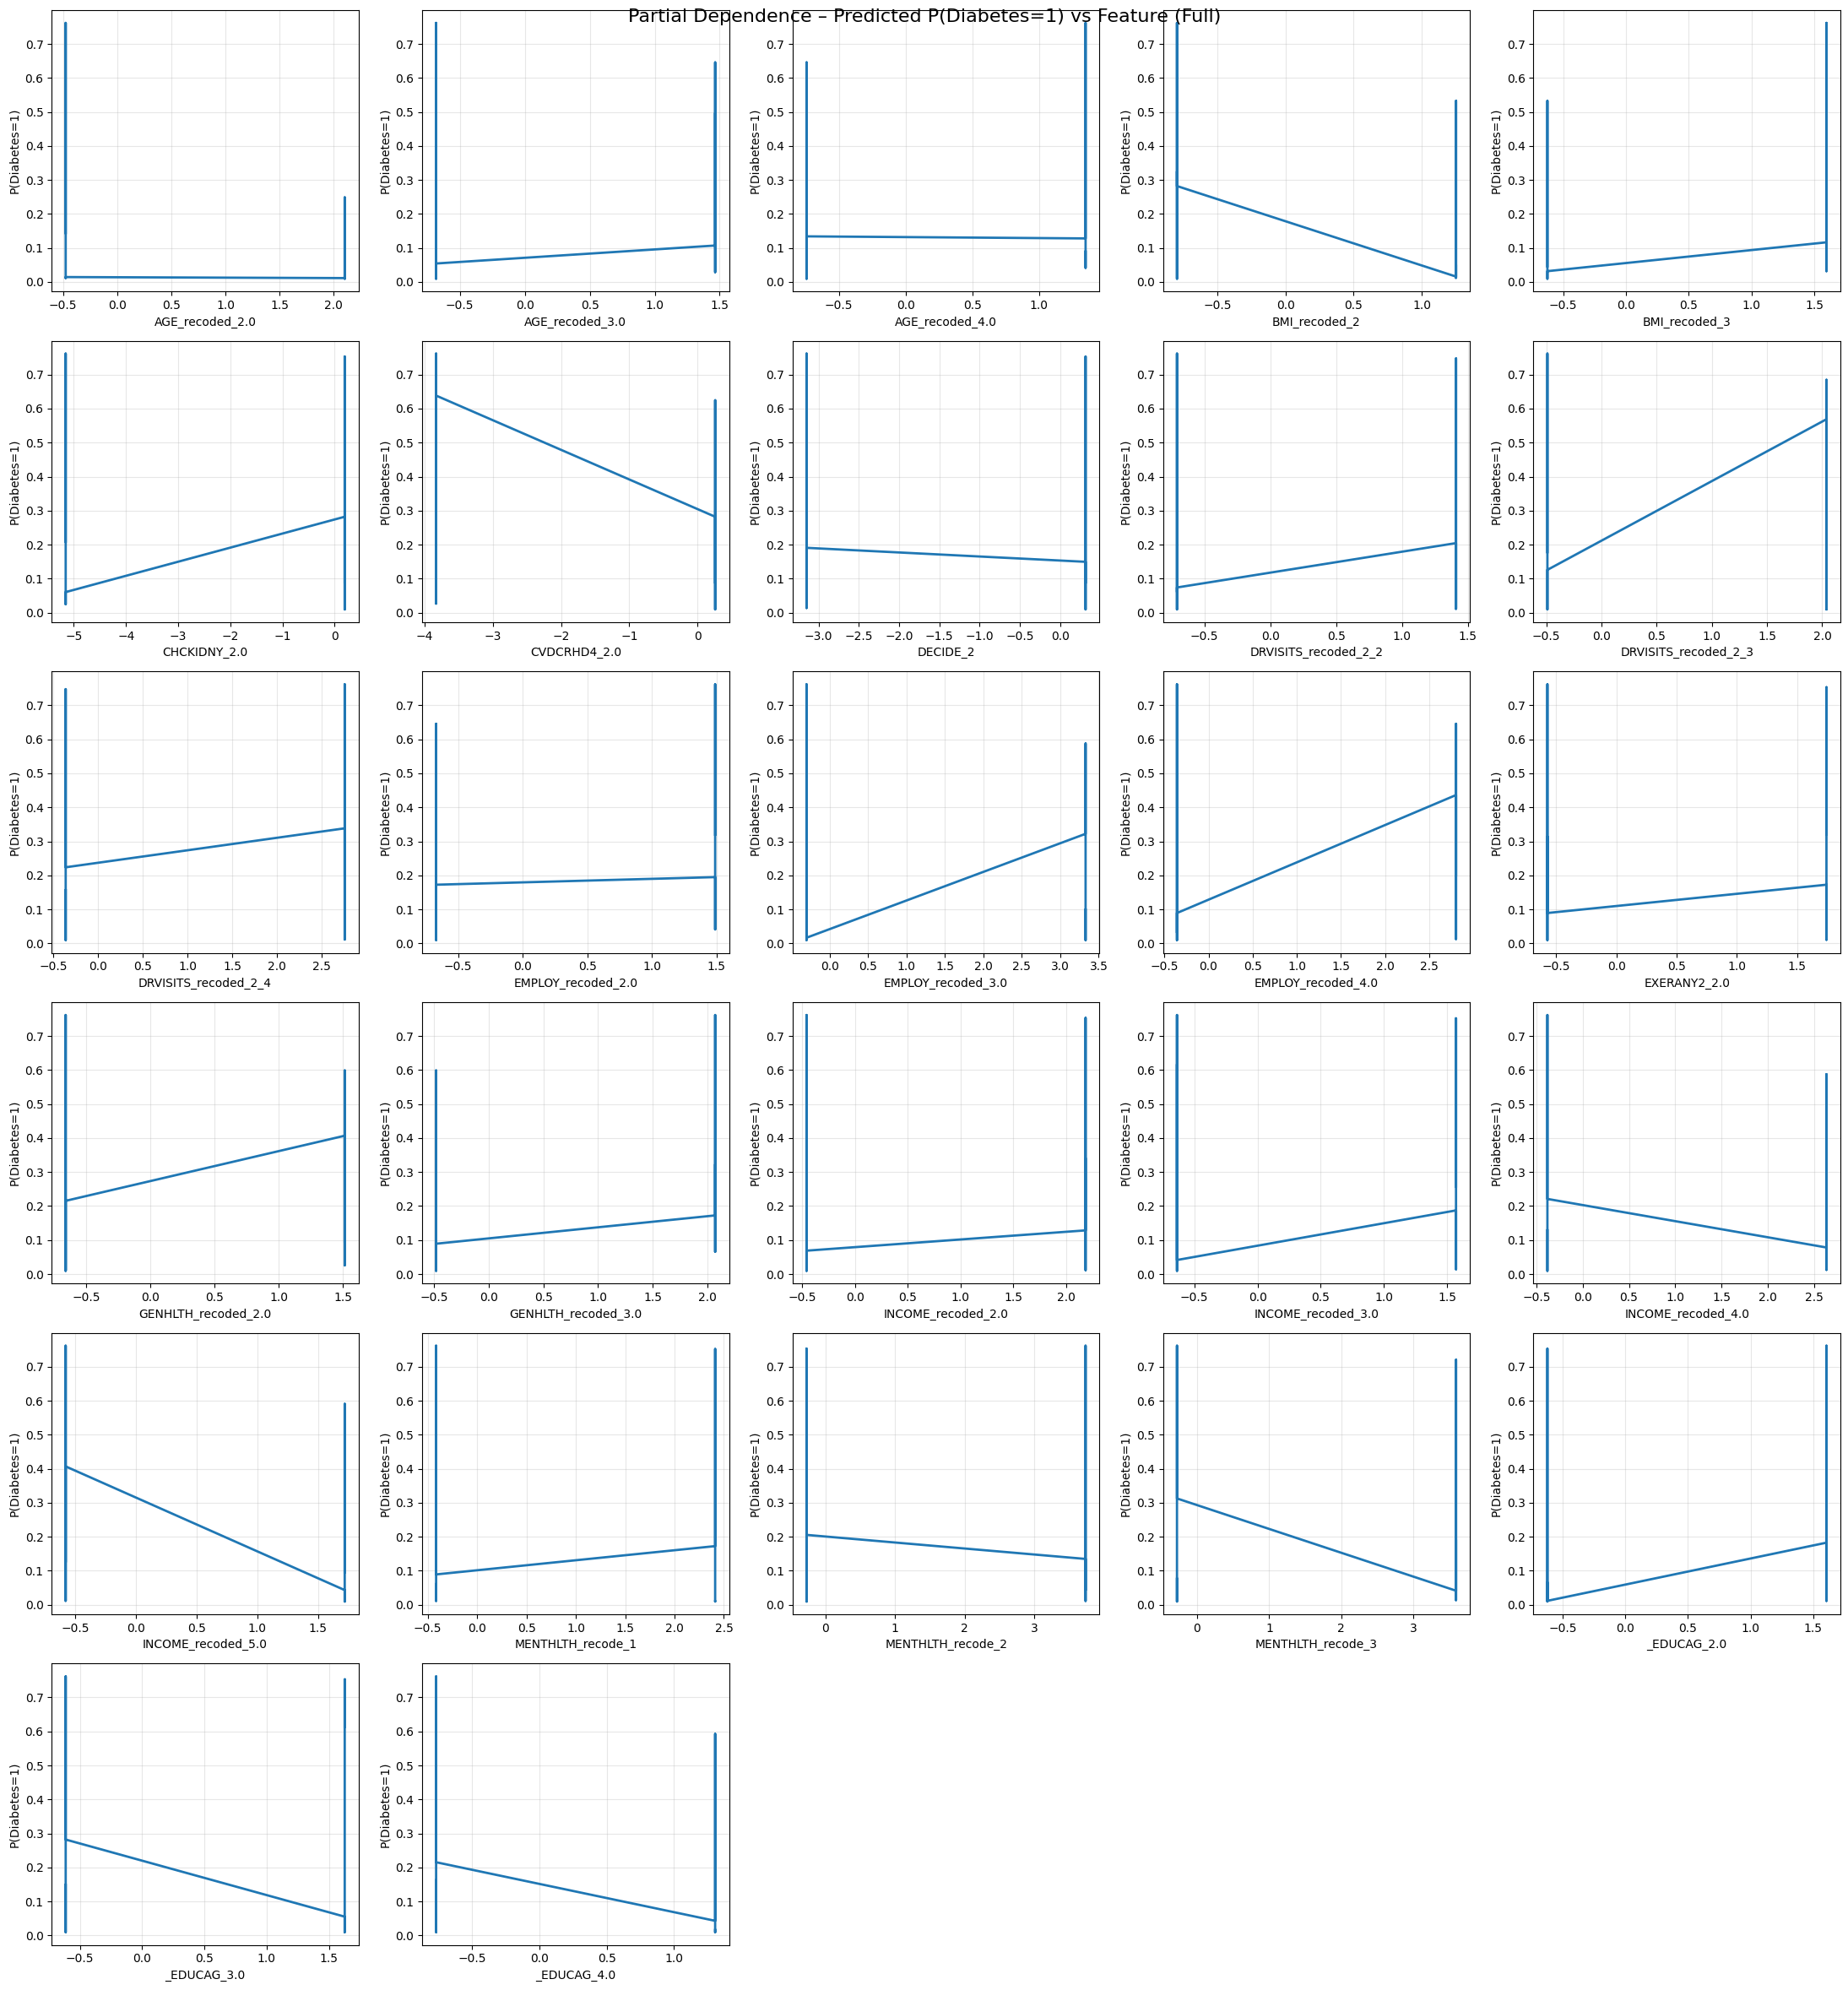

In [20]:
# ------------------------------------------------------------
# DNAMite NAM – FULL FEATURE SET
# ------------------------------------------------------------

# GPU ENABLED (no restriction)
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'   ← REMOVED

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import *
from dnamite.models import DNAMiteBinaryClassifier

# ------------------------------------------------------------
# 1. Load CSVs
# ------------------------------------------------------------
df = pd.read_csv('/content/my_data_3.csv')
X_encoded_df = pd.read_csv('/content/x_encoded_df_2.csv')

print("df shape:", df.shape, " – target:", 'DIABETE3_binary' in df.columns)
print("X_encoded_df shape:", X_encoded_df.shape)

# ------------------------------------------------------------
# 2. Split & scale
# ------------------------------------------------------------
RANDOM_STATE = 42
y = df['DIABETE3_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_df, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

class_counts = y.value_counts()
class_weights = {0:1.0, 1:class_counts[0]/class_counts[1]}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=X_encoded_df.columns, index=X_train.index)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=X_encoded_df.columns, index=X_test.index)

# ------------------------------------------------------------
# 3. SVM baseline
# ------------------------------------------------------------
svm = SVC(kernel='linear', C=0.01, probability=True,
          class_weight=class_weights, random_state=RANDOM_STATE)
svm.fit(X_train_scaled, y_train)

y_score_svm = svm.decision_function(X_test_scaled)
y_pred_svm  = svm.predict(X_test_scaled)

svm_metrics = {
    "name": "SVM (Linear) – Tuned",
    "accuracy": accuracy_score(y_test, y_pred_svm),
    "precision": precision_score(y_test, y_pred_svm, zero_division=0),
    "recall": recall_score(y_test, y_pred_svm),
    "f1": f1_score(y_test, y_pred_svm),
    "roc_auc": roc_auc_score(y_test, y_score_svm)
}
print("\nSVM metrics :", svm_metrics)

# ------------------------------------------------------------
# 4. NAM – FULL FEATURE SET
# ------------------------------------------------------------
# Use all features
X_train_full = X_train_df.copy()
X_test_full  = X_test_df.copy()

nam = DNAMiteBinaryClassifier(
    X_train_full.shape[1],
    max_bins=32,
    min_samples_per_bin=15,
    random_state=RANDOM_STATE
)
nam.fit(X_train_full, y_train)

y_score_nam = nam.predict_proba(X_test_full).flatten()
y_pred_nam  = (y_score_nam >= 0.5).astype(int)

nam_metrics = {
    "name": "DNAMite NAM (full)",
    "accuracy": accuracy_score(y_test, y_pred_nam),
    "precision": precision_score(y_test, y_pred_nam, zero_division=0),
    "recall": recall_score(y_test, y_pred_nam),
    "f1": f1_score(y_test, y_pred_nam),
    "roc_auc": roc_auc_score(y_test, y_score_nam)
}
print("\nNAM (full) metrics :", nam_metrics)

# ------------------------------------------------------------
# 5. Comparison table
# ------------------------------------------------------------
results = pd.DataFrame([svm_metrics, nam_metrics])\
            .sort_values(by=["f1","roc_auc"], ascending=False)
styled = results.style.highlight_max(
    subset=["accuracy","precision","recall","f1","roc_auc"], color="#2E8B57")
display(styled)

# ------------------------------------------------------------
# 6. ROC curve
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
for name, scores in [("SVM", y_score_svm), ("NAM", y_score_nam)]:
    fpr, tpr, _ = roc_curve(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,scores):.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM vs DNAMite NAM (Full Features)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 7. FEATURE IMPORTANCE BAR CHART
# ------------------------------------------------------------
importances_df = nam.get_feature_importances()
importances = importances_df.groupby('feature')['importance'].mean().reset_index()
feat_names = importances['feature'].tolist()
importance_values = importances['importance'].tolist()

plt.figure(figsize=(10,8))
bars = plt.barh(feat_names, importance_values, color='steelblue')
plt.xlabel("Feature Importance")
plt.title("DNAMite – Feature Importance (Full Features)")
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', ha='left', fontsize=9)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8. PARTIAL DEPENDENCE PLOTS (all features)
# ------------------------------------------------------------
n_feats = len(feat_names)
n_rows = (n_feats // 5) + 1
fig, axes = plt.subplots(n_rows, 5, figsize=(22, n_rows * 4))
fig.suptitle("Partial Dependence – Predicted P(Diabetes=1) vs Feature (Full)", fontsize=16)

axes = axes.flatten()

for i, feat in enumerate(feat_names):
    ax = axes[i]
    x = X_test_df[feat].values
    prob = nam.predict_proba(X_test_df).flatten()

    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    prob_sorted = prob[sort_idx]

    ax.plot(x_sorted, prob_sorted, color='tab:blue', linewidth=2)
    ax.set_xlabel(feat)
    ax.set_ylabel("P(Diabetes=1)")
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [21]:
# ------------------------------------------------------------
# DNAMite NAM (FULL FEATURES) + THRESHOLD TUNING
# ------------------------------------------------------------

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import *
from dnamite.models import DNAMiteBinaryClassifier
from sklearn.metrics import precision_recall_curve

# ------------------------------------------------------------
# 1. Load CSVs
# ------------------------------------------------------------
df = pd.read_csv('/content/my_data_3.csv')
X_encoded_df = pd.read_csv('/content/x_encoded_df_2.csv')

# ------------------------------------------------------------
# 2. Split & scale
# ------------------------------------------------------------
RANDOM_STATE = 42
y = df['DIABETE3_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_df, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

class_counts = y.value_counts()
class_weights = {0:1.0, 1:class_counts[0]/class_counts[1]}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=X_encoded_df.columns, index=X_train.index)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=X_encoded_df.columns, index=X_test.index)

# ------------------------------------------------------------
# 3. SVM baseline (for reference)
# ------------------------------------------------------------
svm = SVC(kernel='linear', C=0.01, probability=True,
          class_weight=class_weights, random_state=RANDOM_STATE)
svm.fit(X_train_scaled, y_train)

y_score_svm = svm.decision_function(X_test_scaled)
y_pred_svm  = svm.predict(X_test_scaled)

svm_metrics = {
    "name": "SVM (Linear) – Tuned",
    "accuracy": accuracy_score(y_test, y_pred_svm),
    "precision": precision_score(y_test, y_pred_svm, zero_division=0),
    "recall": recall_score(y_test, y_pred_svm),
    "f1": f1_score(y_test, y_pred_svm),
    "roc_auc": roc_auc_score(y_test, y_score_svm)
}
print("SVM metrics :", svm_metrics)

# ------------------------------------------------------------
# 4. NAM – FULL FEATURE SET
# ------------------------------------------------------------
X_train_full = X_train_df.copy()
X_test_full  = X_test_df.copy()

nam = DNAMiteBinaryClassifier(
    X_train_full.shape[1],
    max_bins=32,
    min_samples_per_bin=15,
    random_state=RANDOM_STATE
)
nam.fit(X_train_full, y_train)

y_score_nam = nam.predict_proba(X_test_full).flatten()

# ------------------------------------------------------------
# 5. THRESHOLD TUNING: Match SVM recall (~0.702)
# ------------------------------------------------------------
prec, rec, thresh = precision_recall_curve(y_test, y_score_nam)
target_recall = 0.702
idx = np.argmin(np.abs(rec - target_recall))
best_thresh = thresh[idx] if idx < len(thresh) else 0.5

print(f"\nThreshold tuning: target recall = {target_recall}")
print(f"→ Best threshold = {best_thresh:.4f}")
print(f"   Recall = {rec[idx]:.4f}, Precision = {prec[idx]:.4f}")

y_pred_tuned = (y_score_nam >= best_thresh).astype(int)

nam_tuned_metrics = {
    "name": "DNAMite NAM (full, tuned)",
    "accuracy": accuracy_score(y_test, y_pred_tuned),
    "precision": precision_score(y_test, y_pred_tuned, zero_division=0),
    "recall": recall_score(y_test, y_pred_tuned),
    "f1": f1_score(y_test, y_pred_tuned),
    "roc_auc": roc_auc_score(y_test, y_score_nam)
}
print("\nTuned NAM (full) metrics :", nam_tuned_metrics)

# ------------------------------------------------------------
# 6. Final comparison table
# ------------------------------------------------------------
results = pd.DataFrame([svm_metrics, nam_tuned_metrics])\
            .sort_values(by=["f1","roc_auc"], ascending=False)
styled = results.style.highlight_max(
    subset=["accuracy","precision","recall","f1","roc_auc"], color="#2E8B57")
display(styled)

SVM metrics : {'name': 'SVM (Linear) – Tuned', 'accuracy': 0.718, 'precision': 0.2920353982300885, 'recall': 0.7021276595744681, 'f1': 0.4125, 'roc_auc': np.float64(0.7857520289962763)}

Threshold tuning: target recall = 0.702
→ Best threshold = 0.1489
   Recall = 0.7021, Precision = 0.2773

Tuned NAM (full) metrics : {'name': 'DNAMite NAM (full, tuned)', 'accuracy': 0.7, 'precision': 0.2773109243697479, 'recall': 0.7021276595744681, 'f1': 0.39759036144578314, 'roc_auc': np.float64(0.7741188418002131)}


,name,accuracy,precision,recall,f1,roc_auc
0,SVM (Linear) – Tuned,0.718000,0.292035,0.702128,0.412500,0.785752
1,"DNAMite NAM (full, tuned)",0.700000,0.277311,0.702128,0.397590,0.774119
